<a href="https://colab.research.google.com/github/jcandane/LexicographicSort/blob/main/ssort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time
from numba import njit
import matplotlib.pyplot as plt

In [19]:
!pip3 install tikzplotlib
!git clone https://github.com/jcandane/pyprototyp



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'pyprototyp' already exists and is not an empty directory.


In [20]:
import tikzplotlib
from pyprototyp.pyprototyp import pyprototyp

## binary search

In [4]:
@njit ## for numba (comment out if not needed)
def L_binarysearch(A, T, L=0, R=None):
    """
    np.searchsorted has no contraints, i.e. L nor R
    GIVEN:  A (1d sorted numpy.array)
            T (searched for entry)
            *L (lowest  index to search for)
            *R (highest index to search for)
    GET:    L (left-(lowest) most index of entry)
    """
    if R is None:
        R = len(A)
    while L < R:
        m = (L + R) // 2
        if A[m] < T:
            L = m + 1
        else:
            R = m
    return L

@njit ## for numba (comment out if not needed)
def R_binarysearch(A, T, L=0, R=None):
    """
    np.searchsorted has no contraints, i.e. L nor R
    GIVEN:  A (1d sorted numpy.array)
            T (searched for entry)
            *L (lowest  index to search for)
            *R (highest index to search for)
    GET:    R (right-(highest) most index of entry)
    """
    if R is None:
        R = len(A)
    while L < R:
        m = (L + R) // 2
        if A[m] > T:
            R = m
        else:
            L = m + 1
    return R

@njit ## for numba (comment out if not needed)
def interval_binarysearch(A, value, L=0, R=None):
    return L_binarysearch(A, value, L=L, R=R), R_binarysearch(A, value, L=L, R=R)

@njit ## for numba (comment out if not needed)
def tuplebsearch_interval(B, value, L=0, R=None):
    for columns in range(B.shape[0]): ### over entries/columns of the tuple
        L, R = interval_binarysearch(B[columns,:], value[columns], L=L, R=R)
    return L, R

## domain finder

In [5]:
def linear_domain(A):
    """
    GIVEN:  A (sorted 1d numpy array)
    GET:    domains (sorted 1d numpy array, ranges of unique elements)
    """
    domain = np.where( np.diff( A , prepend=-1, append=len(A)) != 0)[0]
    return domain

def log_domain(A):
    """
    GIVEN:  A (sorted 1d numpy array)
    GET:    domains (sorted 1d numpy array, ranges of unique elements)
    """
    domain = [0]
    while domain[-1]!=len(A):
        domain.append( R_binarysearch(A, A[domain[-1]], L=domain[-1], R=None) )
    return np.asarray(domain)

def domain_finder(A):
    """
    GIVEN:  A (sorted 1d numpy array)
    GET:    domains (sorted 1d numpy array, ranges of unique elements)
    """
    if (A[-1]-A[0]) < len(A).bit_length() - 1:
        return log_domain(A) # log_domain_finder(A)
    else:
        return linear_domain(A) # linear_domain_finder(A)



B = np.sort( np.random.randint(15, size=100) )
print(B)

print( linear_domain(B) )
print( log_domain(B) )
print( domain_finder(B) )

[ 0  0  0  0  0  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  3  3  3  3
  3  3  3  4  4  4  4  4  4  4  4  5  5  6  6  6  6  6  6  6  6  6  6  7
  7  7  7  8  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9 10 10 10
 10 10 10 10 11 11 11 11 11 12 12 12 12 12 12 13 13 13 13 13 13 13 13 14
 14 14 14 14]
[  0   5  11  20  27  35  37  47  51  59  69  76  81  87  95 100]
[  0   5  11  20  27  35  37  47  51  59  69  76  81  87  95 100]
[  0   5  11  20  27  35  37  47  51  59  69  76  81  87  95 100]


## lexicographic sort

In [6]:
def ssort(A, return_unique=False):
    """
    GIVEN:  A (2d numpy array of shape (tuple, list))
            *return_unique (boolean, choice to output indices and uniques)
    GET:    A lexicographically-sorted along 2nd (list) index.
    """

    ARG = np.argsort(A[0] , kind="mergesort")
    A   = A[:,ARG]
    
    ikk = np.array([], dtype=np.int32)
    for k in range(1,len(A)):
        ik = np.where( np.diff(A[k-1], prepend=A[k-1,0]-1, append=A[k-1,-1]+1) != 0)[0]
        ik = np.union1d(ikk, ik)
        for l in range(len(ik)-1): ## For
            argssort = np.argsort(A[k,ik[l]:ik[l+1]] , kind="mergesort")
            A[:,ik[l]:ik[l+1]] = (A[:,ik[l]:ik[l+1]])[:,argssort]
            ARG[ik[l]:ik[l+1]] = (ARG[ik[l]:ik[l+1]])[argssort]
        ikk = 1*ik

    k = len(A)-1 ## 8/30
    if return_unique:
        return A, ARG, ik
    return A

## tuple comparison

In [7]:
@njit
def tuple_comparison(A,B): ## A < B?
    for ba in (B-A):
        if ba > 0: ## find the first nonzero positive entry
            return True
    return False

tuple_a = np.array([1,2,3])
tuple_b = np.array([1,1,3])

print( tuple_comparison(tuple_b,tuple_a) )

True


## random list-of-tuples

In [8]:
A = ssort( np.random.randint(10, size=(4,100)) )

## binary search example

In [9]:
LR = L_binarysearch(A[0], 5, L=0, R=None), R_binarysearch(A[0], 5, L=0, R=None)
A[0,LR[0]:LR[1]]

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

## testing ssort

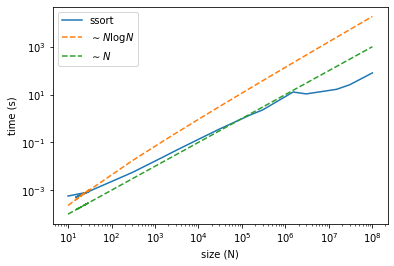

In [13]:
AA = np.random.randint(100, size=(4,30000000))

N = np.array([10,30,15,300,1500,3000,10000,30000,150000,300000,1500000,3000000, 15000000, 30000000, 100000000])
y = np.zeros(len(N))
for i in range(len(N)):
    start = time.time()
    ssort(np.random.randint(100, size=(4,N[i])))
    y[i] = (time.time()-start)

plt.plot(N,y, label="ssort")
plt.plot(N, (N*np.log(N))*0.00001, label="$\sim N\log N$", linestyle="dashed")
plt.plot(N, (N)*0.00001, label="$\sim N$", linestyle="dashed")
plt.ylabel("time (s)")
plt.xlabel("size (N)")
plt.yscale('log')
plt.xscale('log')
plt.legend()
tikzplotlib.save("mytikz.tex")
plt.show()

In [22]:
pyprototyp("lexssort", packages=["import time","from numba import njit"], useful=[], defs=[L_binarysearch, R_binarysearch, interval_binarysearch, tuplebsearch_interval, linear_domain, log_domain, domain_finder, ssort, tuple_comparison], classes=[])